In [1]:
import os
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid") # better looking plots
import wandb
from multiprocessing import Process

print("Using GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Using backend: pytorch
Other available backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
 


Using GPU: True


# Solving the BVP using deepxde

In this work we adress the boundary value problem introduced in [1] that has an analytical solution (considering linear elasticity).

We consider the unit square domain : $\Omega = [0,1]^2$, on which the continnum mechanics equations applies :

$ \epsilon_{ij} = \frac{1}{2}(u_{i,j}+u_{j,i}) $\
$ \sigma_{ij} =  \lambda \epsilon_{ij} \delta{ij} + 2 \mu \epsilon_{ij}$\
$ \sigma_{ij,j} + f_{i} = 0 $

The body forces are choosen on purpose so that there can be an analytical solution :

$f_x = \lambda \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 4 \pi^{2} \sin{\left(2 \pi y \right)} \cos{\left(2 \pi x \right)}\right) + \mu \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 9 \pi^{2} \sin{\left(\pi y \right)}\right)$\
$f_y = \lambda \left(- 3 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right) + \mu \left(\frac{\pi^{2} Q y^{4} \sin{\left(\pi x \right)}}{16} - 6 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right)$

[1] Haghighat, Ehsan, Maziar Raissi, Adrian Moure, Hector Gomez, and Ruben Juanes. “A Deep Learning Framework for Solution and Discovery in Solid Mechanics.” 

In [2]:
# plotting utilities
def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(domain,model,output_func=None,V_exact=None,plot_diff=False,n_points=10000,fields_name=None):

    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

    plotify = lambda x: x.reshape(Xgrid.shape)

    if output_func is None:
        V_nn = model.predict(Xinput)
    else:
        V_nn = model.predict(Xinput, operator=output_func)

    V_nn = [plotify(V) for V in V_nn]

    n_fields = len(V_nn) if type(V_nn) is list else 1
    n_plot = 1

    if fields_name is None:
        fields_name = V_exact.__name__.replace('_exact','') if V_exact is not None else 'V'

    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]
    fields_name = [fields_name + coord[i] for i in range(n_fields)]

    if V_exact is not None:
        V_exact = V_exact(Xinput)
        V_exact = [plotify(V) for V in V_exact]
        n_plot = 3 if plot_diff else 2
        
    fig, ax = plt.subplots(n_fields, n_plot, figsize=(4*n_plot, 3*n_fields), dpi=200)

    for i in range(n_fields):
        subax = ax if n_fields == 1 else ax[i] 

        if V_exact is not None:

            cmax = max(V_nn[i].max(), V_exact[i].max())
            cmin = min(V_nn[i].min(), V_exact[i].min())

            im1 = pcolor_plot(subax[0], Xgrid, Ygrid, V_exact[i], f"{fields_name[i]}*", cmin=cmin, cmax=cmax)
            im2 = pcolor_plot(subax[1], Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn", cmin=cmin, cmax=cmax)

            fig.colorbar(im1, ax=subax[1])
        else:
            im1 = pcolor_plot(subax, Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn")
            fig.colorbar(im1, ax=subax)

        if plot_diff:
            diff = V_nn[i] - V_exact[i]
            abs_diff = np.abs(diff)
            cmax = abs_diff.max() if diff.max() > 0 else 0
            cmin = -abs_diff.max() if diff.min() < 0 else 0
            im3 = pcolor_plot(subax[2], Xgrid, Ygrid,diff, f"{fields_name[i]}_nn - {fields_name[i]}*", cmin=cmin, cmax=cmax, colormap="coolwarm")
            fig.colorbar(im3, ax=subax[2])
            subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")

    return fig

## Analytical solution of the boundary value problem

In [3]:
lmbd = 1.0
mu = 0.5
Q = 4.0

def U_exact(X):
    x, y = X[:,0], X[:,1]
    #displacement U
    Ux = np.cos(2*np.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return np.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1)))

def E_exact(X):
    #strain E
    x, y = X[:,0], X[:,1]
    Exx = -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    Eyy = np.sin(np.pi*x)*Q*y**3
    Exy = 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return (Exx, Eyy, Exy)

def S_exact(X):
    #stress S
    Sxx = (lmbd + 2*mu) * E_exact(X)[0] + lmbd * E_exact(X)[1]
    Syy = (lmbd + 2*mu) * E_exact(X)[1] + lmbd * E_exact(X)[0]
    Sxy = 2*mu*E_exact(X)[2]
    return (Sxx, Syy, Sxy)

def bodyf_exact(X):
    #body force
    x, y = X[:,0], X[:,1]
    fx = lmbd*(4*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y)-np.pi*np.cos(np.pi*x)*Q*y**3) \
        + mu*(9*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y) - np.pi*np.cos(np.pi*x)*Q*y**3)
    fy = lmbd*(-3*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y)) \
        + mu*(-6*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y) + (np.pi**2*np.sin(np.pi*x)*Q*y**4)/4)
    return (fx, fy)
    
def E_potential_exact(X):
    #potential energy
    E_strain = 1/2 * (E_exact(X)[0]*S_exact(X)[0] + E_exact(X)[1]*S_exact(X)[1] + 2*E_exact(X)[2]*S_exact(X)[2])
    W_bodyf = U_exact(X)[:,0]*bodyf_exact(X)[0] + U_exact(X)[:,1]*bodyf_exact(X)[1]
    E_potential = E_strain - W_bodyf +100 #+100 to remain positive
    return [E_potential]

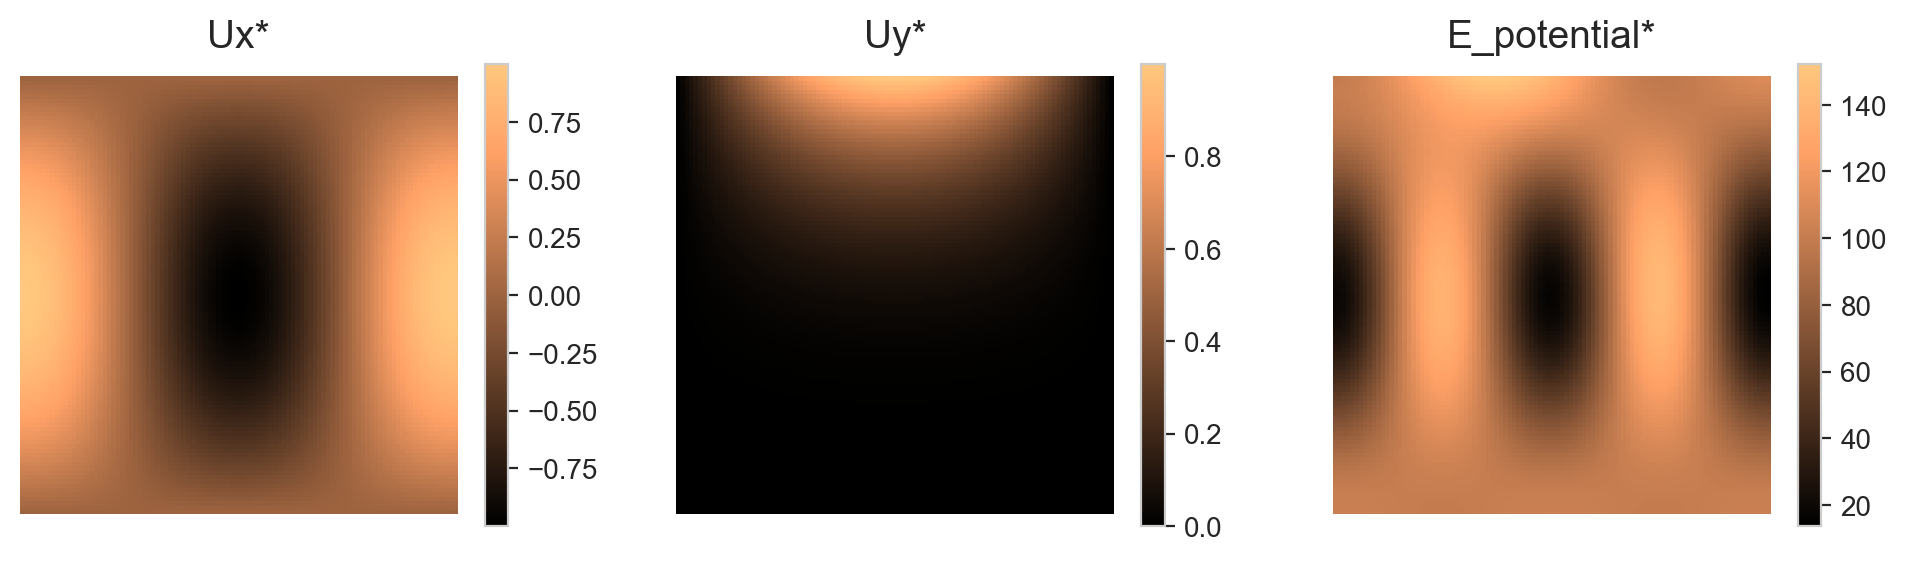

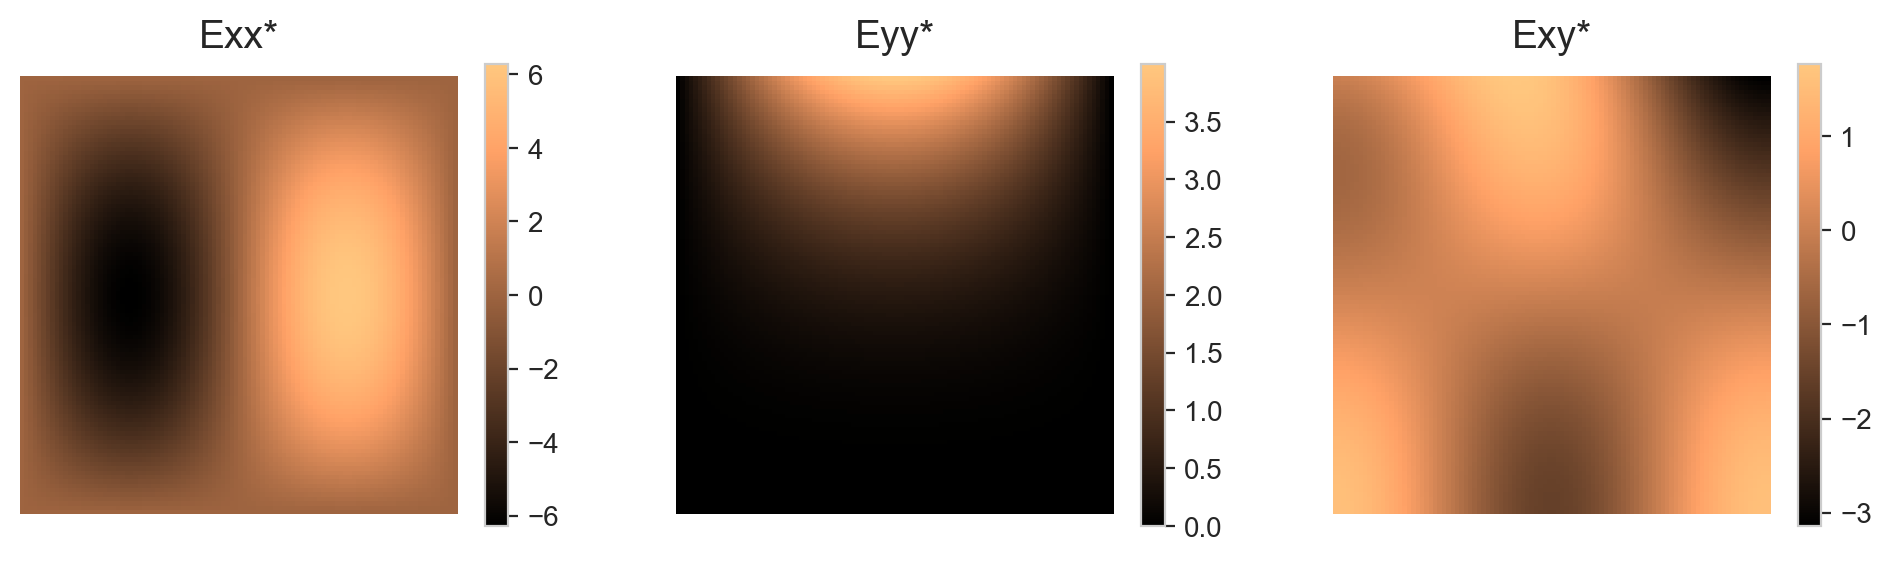

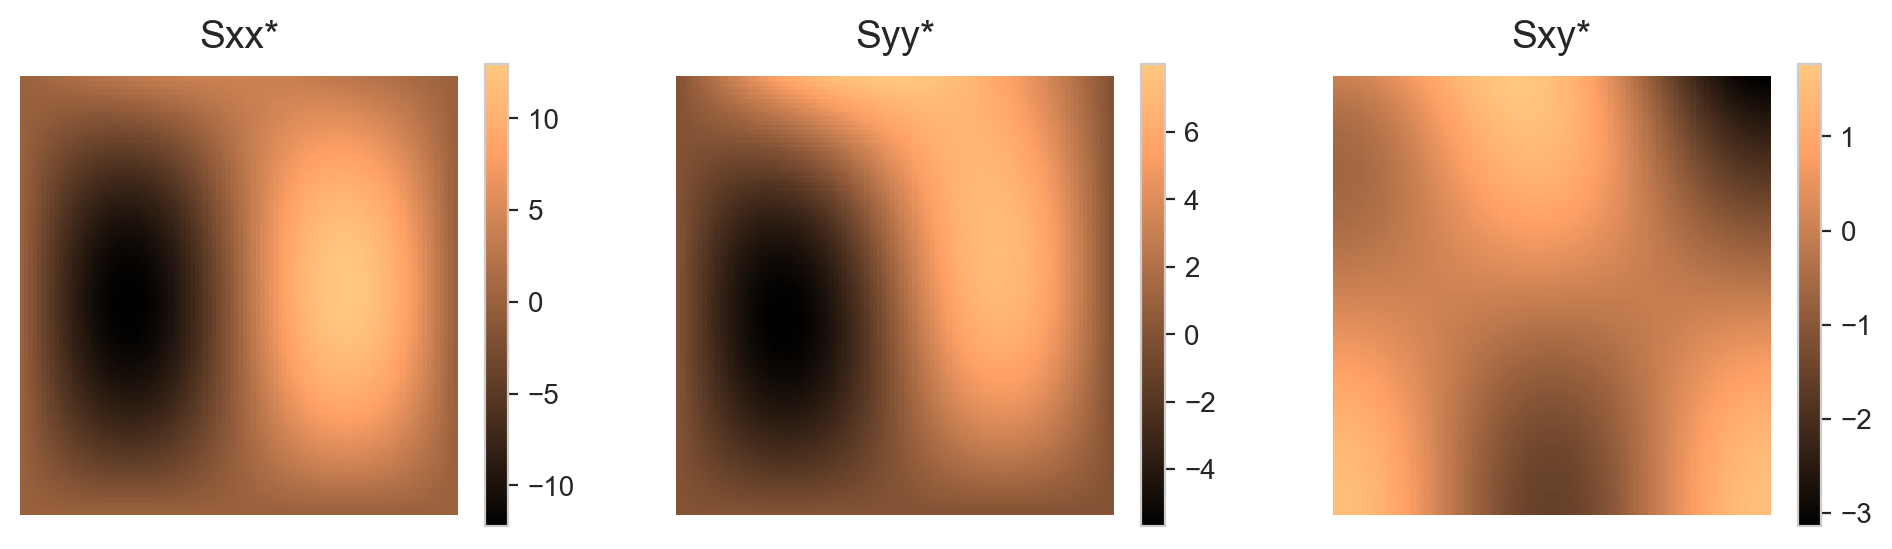

In [4]:
#plotting the analytical solution
lmbd = 1.0
mu = 0.5
Q = 4.0

domain = np.array([[0.0, 1.0], [0.0, 1.0]])

X = np.linspace(domain[0][0], domain[0][1], 100)
Y = np.linspace(domain[1][0], domain[1][1], 100)
Xgrid, Ygrid = np.meshgrid(X, Y)
Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(2):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, U_exact(Xinput)[:,i].reshape(Xgrid.shape), ["Ux*", "Uy*"][i])
    fig.colorbar(im, ax=ax[i])
im = pcolor_plot(ax[2], Xgrid, Ygrid, E_potential_exact(Xinput)[0].reshape(Xgrid.shape), "E_potential*")
fig.colorbar(im, ax=ax[2])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(3):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, E_exact(Xinput)[i].reshape(Xgrid.shape), ["Exx*", "Eyy*", "Exy*"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
for i in range(3):
    im = pcolor_plot(ax[i], Xgrid, Ygrid, S_exact(Xinput)[i].reshape(Xgrid.shape), ["Sxx*", "Syy*", "Sxy*"][i])
    fig.colorbar(im, ax=ax[i])

## PINN implementation with DeepXDE

In [5]:
# physical functions for tensors (output of the network) using deepxde differential operators
def bodyf(X, mu, lmbd):
    #body force
    x, y = X[:,0:1], X[:,1:2]
    fx = lmbd*(4*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y)-torch.pi*torch.cos(torch.pi*x)*Q*y**3) \
        + mu*(9*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y) - torch.pi*torch.cos(torch.pi*x)*Q*y**3)
    fy = lmbd*(-3*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y)) \
        + mu*(-6*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y) + (torch.pi**2*torch.sin(torch.pi*x)*Q*y**4)/4)
    return (fx, fy)

def E_nn(X,U):
    """calculate the strain given the displacement"""
    Exx = dde.grad.jacobian(U, X, i=0, j=0)
    Eyy = dde.grad.jacobian(U, X, i=1, j=1)
    Exy = 0.5 * (dde.grad.jacobian(U, X, i=1, j=0) +dde.grad.jacobian(U, X, i=0, j=1))
    return Exx, Eyy, Exy

def S_nn(E):
    """calculate the stress given the strain"""
    Sxx = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy = 2 * mu * E[2]
    return Sxx, Syy, Sxy

def PDE(X,S):
    """
    the PDE of the problem (momentum balance)
    X is the spatial coordinate of shape (N,2) (x,y) 
    S is the stress tensor of shape (N,3) (Sxx, Syy, Sxy)
    """

    Sxx, Syy, Sxy = S
    S = torch.stack((Sxx.reshape(-1,1), Syy.reshape(-1,1), Sxy.reshape(-1,1)), axis=1)
        
    dSxx_x = dde.grad.jacobian(S, X, i=0, j=0)
    dSyy_y = dde.grad.jacobian(S, X, i=1, j=1)
    dSxy_x = dde.grad.jacobian(S, X, i=2, j=0)
    dSxy_y = dde.grad.jacobian(S, X, i=2, j=1)
    
    fx, fy = bodyf(X, mu, lmbd)

    momentum_x = dSxx_x + dSxy_y + fx
    momentum_y = dSyy_y + dSxy_x + fy
    
    return [momentum_x, momentum_y]

def E_potential(U,E,S,bodyf):
    """
    calculate the potential energy of the system
    U is the displacement tensor of shape (N,2) U[:,0] = Ux, U[:,1] = Uy
    E is the strain of list of length 3 (Exx, Eyy, Exy)
    S is the stress of list of length 3 (Sxx, Syy, Sxy)
    bodyf is the body force of list of length 2 (fx, fy)
    """
    strain_energy = 0.5 * (S[0]*E[0] + S[1]*E[1] + 2*S[2]*E[2])
    bodyf_work = U[:,0:1] * bodyf[0] + U[:,1:2] * bodyf[1]
    E_pot = strain_energy - bodyf_work
    return E_pot

def Material_error(E,S,lmbd,mu):
    """
    calculate the material behavior error
    E is the strain of list of length 3 (Exx, Eyy, Exy)
    S is the stress of list of length 3 (Sxx, Syy, Sxy)
    lmbd and mu are the material properties for linear elasticity
    """
    Sxx, Syy, Sxy = S
    
    Sxx_pred = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy_pred = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy_pred = 2 * mu * E[2]

    Material_error = torch.square(Sxx - Sxx_pred) + torch.square(Syy - Syy_pred) + torch.square(Sxy - Sxy_pred)
    return Material_error

## Direct and parallel implementation (displacement as output, or displacement and stress as output)

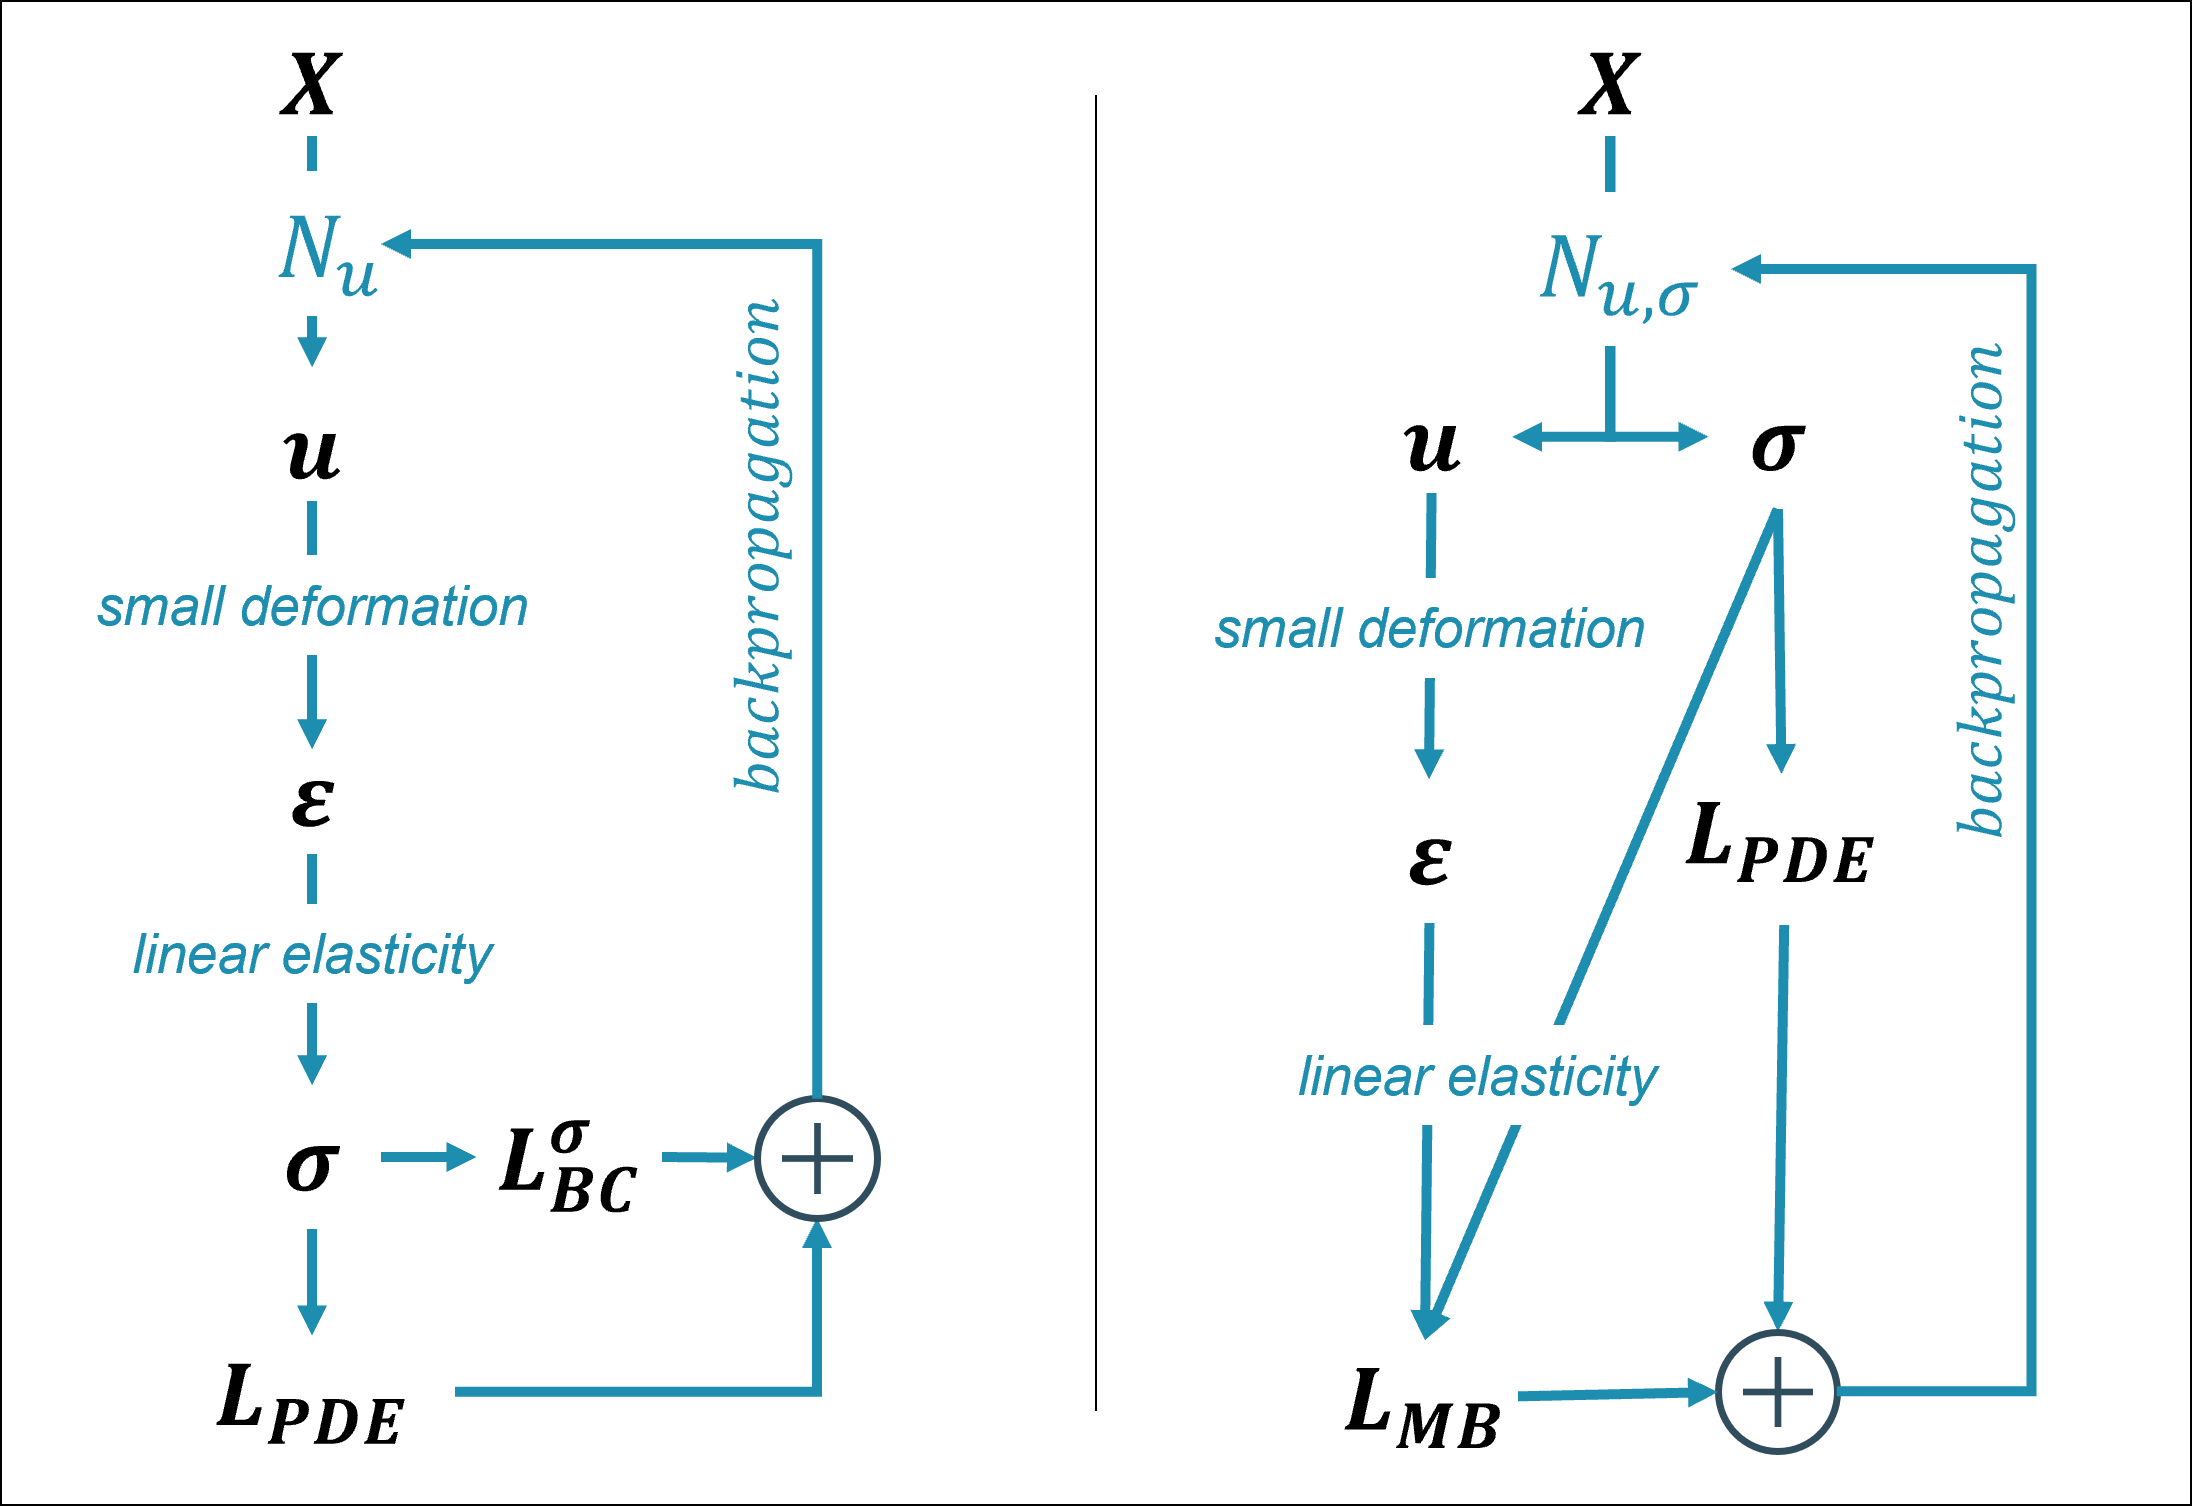

In [7]:
Image(filename=r'../figures/PINN_implementation.png', width=600)
# Left: direct implementation ; Right: parallel implementation

### Define the loss functions (PDE and $E_{pot}$)

In [8]:
#Unet : direct implementation ; u_x, u_y as output of the network
def PDE_Unet(x,net_output):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,2), the displacement u_x and u_y
    return: the PDE of the problem
    """
    E = E_nn(x,net_output)
    S = S_nn(E)
    pde = PDE(x,S)
    return pde

def Epot_Unet(x,net_output):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,2), the displacement u_x and u_y
    return: the potential energy of the system
    """
    E = E_nn(x,net_output)
    S = S_nn(E)
    bodyf_val = bodyf(x, mu, lmbd)
    E_pot = E_potential(net_output,E,S,bodyf_val)
    return [E_pot]

#USnet : parallel implementation ; u_x, u_y, S_xx, S_yy, S_xy as output of the network
def PDE_USnet(x,net_output):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,5), the displacement u_x, u_y, the stress S_xx, S_yy, S_xy, only the stress is used in the PDE
    return: the PDE of the problem
    """
    S = net_output[:,2], net_output[:,3], net_output[:,4]
    pde = PDE(x,S)
    return pde

def Epot_USnet(x,net_output):
    """
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,5), the displacement u_x, u_y, the stress S_xx, S_yy, S_xy, only the stress is used in the potential energy
    return: the potential energy of the system
    """
    U = torch.hstack((net_output[:,0].reshape(-1,1),net_output[:,1].reshape(-1,1)))
    E = E_nn(x,U)
    S = S_nn(E)
    bodyf_val = bodyf(x, mu, lmbd)
    E_pot = E_potential(U,E,S,bodyf_val)
    return [E_pot]

def MaterialError_USnet(x,net_output):
    """
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,5), the displacement u_x, u_y, the stress S_xx, S_yy, S_xy
    return: the material behavior error: the squared difference between the stress predicted by the network and the stress predicted by the linear elasticity from the displacement 
    """
    U = torch.hstack((net_output[:,0].reshape(-1,1),net_output[:,1].reshape(-1,1)))
    E = E_nn(x,U)
    S = net_output[:,2].reshape(-1,1), net_output[:,3].reshape(-1,1), net_output[:,4].reshape(-1,1)
    return [Material_error(E,S,lmbd,mu)]

### Imposing the boundary conditions (hard or soft)

In [9]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])

#Hard boundary conditions for Unet and USnet (for Unet, hard BCs are applied to displacement only -> soft BCs must be additionnaly applied to stress)
def HardBC_Unet(x,net_output):  
    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

def HardBC_USnet(x,net_output):
    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]

    Sxx = net_output[:,2]*x[:,0]*(1-x[:,0])
    Syy = net_output[:,3]*(1-x[:,1]) + (lmbd + 2*mu)*Q*torch.sin(torch.pi*x[:,0])
    Sxy = net_output[:,4] 
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1),Sxx.reshape(-1,1),Syy.reshape(-1,1),Sxy.reshape(-1,1))) 

#Soft boundary conditions
def boundary_Ux(x,_):
    return np.isclose(x[1], 0) or np.isclose(x[1], 1)

def boundary_Uy(x,_):
    return np.isclose(x[0], 0) or np.isclose(x[0], 1) or np.isclose(x[1], 0)

def boundary_Sxx(x,_):
    return np.isclose(x[0], 0) or np.isclose(x[0], 1)

def boundary_Syy(x,_):
    return np.isclose(x[1], 1)

def BCvalue_Syy(x):
    return (lmbd + 2*mu)*Q*torch.sin(torch.pi*x[:,0])

def Sxx_Unet(inputs, outputs, X):
    E_pred = E_nn(inputs,outputs)
    S_pred = S_nn(E_pred)
    Sxx_pred = S_pred[0]
    return torch.square(Sxx_pred)

def Syy_Unet(inputs, outputs, X):
    E_pred = E_nn(inputs,outputs)
    S_pred = S_nn(E_pred)
    Syy_pred = S_pred[1].squeeze()
    return torch.square(Syy_pred - BCvalue_Syy(inputs))

bc_Ux = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_Ux, component=0)
bc_Uy = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_Uy, component=1)

In [10]:
#setup the network architecture (loss and BCs)
def net_setup(net,net_type,bc_type,loss_type):
    if net_type == 'Unet':
        bc_Sxx = dde.icbc.OperatorBC(geom, Sxx_Unet, boundary_Sxx)
        bc_Syy = dde.icbc.OperatorBC(geom, Syy_Unet, boundary_Syy)
        if bc_type == 'soft':
            bc = [bc_Ux,bc_Uy,bc_Sxx,bc_Syy]
        elif bc_type == 'hard':
            bc = [bc_Sxx,bc_Syy] #Soft BCs for stress
            net.apply_output_transform(HardBC_Unet)
        pde_net = PDE_Unet
        energy_net = Epot_Unet
        mat_net = lambda x,net_output: 0 #No material error for Unet architecture (stress is computed from displacement using the constitutive law)
        if loss_type == 'pde':
            total_loss = pde_net
        elif loss_type == 'energy':
            total_loss = energy_net

    elif net_type == 'USnet':
        #BCs  
        if bc_type == 'soft':
            bc_Sxx = dde.NeumannBC(geom, lambda x: 0, boundary_Sxx, component=2)
            bc_Syy = dde.NeumannBC(geom, BCvalue_Syy, boundary_Syy, component=3)
            bc = [bc_Ux,bc_Uy,bc_Sxx,bc_Syy]
        elif bc_type == 'hard':
            bc = []
            net.apply_output_transform(HardBC_USnet)
        #Loss
        pde_net = PDE_USnet
        energy_net = Epot_USnet
        mat_net = MaterialError_USnet
        phy_loss = pde_net if loss_type == 'pde' else energy_net
        # Material error is always added to the loss for USnet architecture
        total_loss = lambda x,net_output: phy_loss(x,net_output) + mat_net(x,net_output)

    return net,total_loss,bc,pde_net,energy_net,mat_net

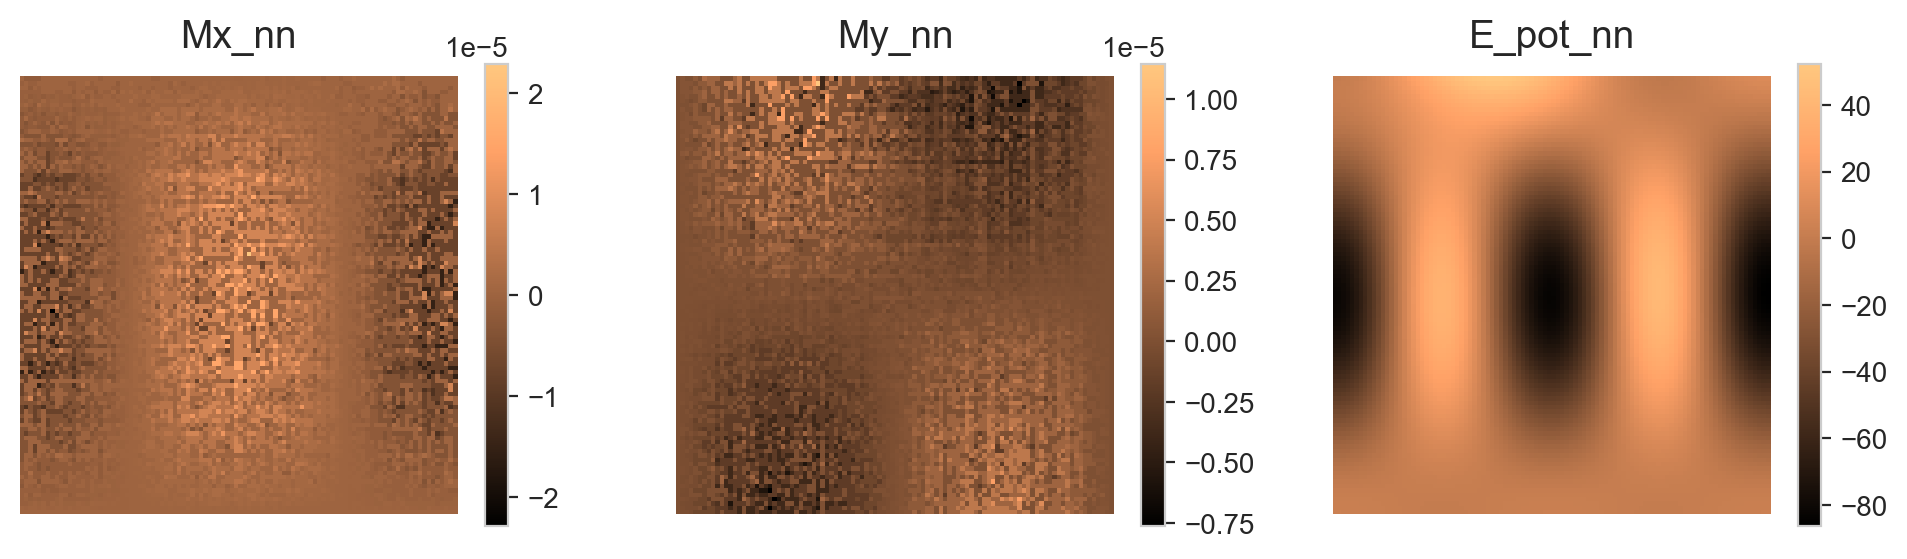

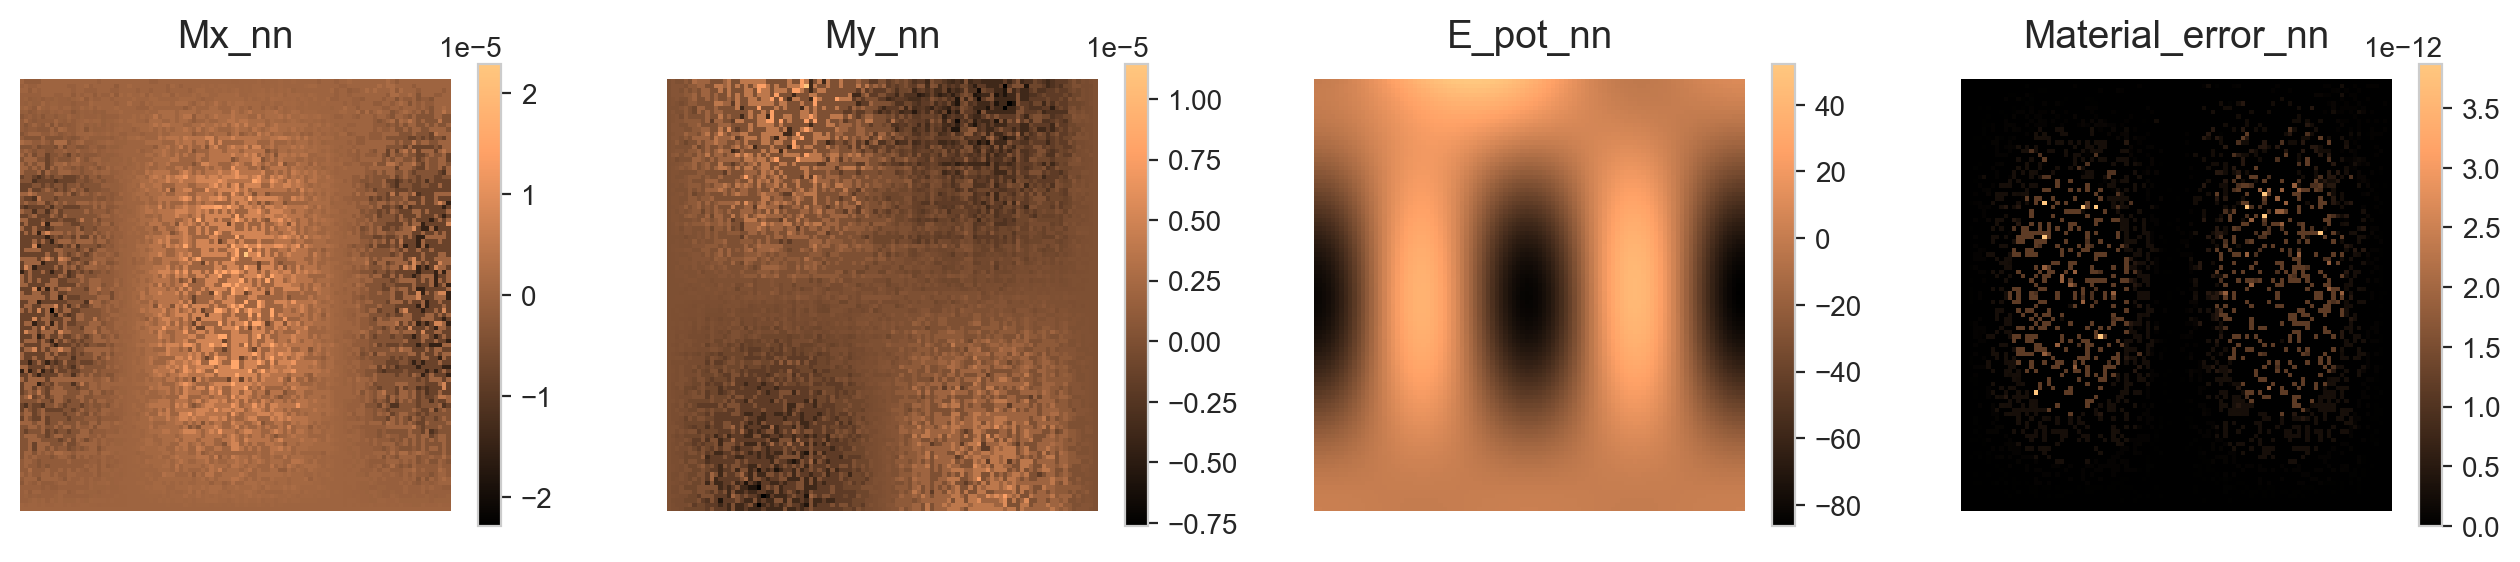

In [11]:
#check that loss functions (PDE and energy) are minimized by the exact solution

#Unet exact solution (direct implementation)
def Unet_exact(x,lib='np'):
    if lib == 'torch':
        cos,sin,pi,hstack = torch.cos,torch.sin,torch.pi,torch.hstack
    elif lib == 'np':
        cos,sin,pi,hstack = np.cos,np.sin,np.pi,np.hstack
    # ground truth displacement
    Ux = cos(2*pi*x[:,0]) * sin(pi*x[:,1])
    Uy = sin(pi*x[:,0]) * Q * x[:,1]**4/4
    return hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

#USnet exact solution (parallel implementation)
def USnet_exact(x,lib='np'):
    # ground truth output of the network
    if lib == 'torch':
        cos,sin,pi,hstack = torch.cos,torch.sin,torch.pi,torch.hstack
    elif lib == 'np':
        cos,sin,pi,hstack = np.cos,np.sin,np.pi,np.hstack

    Ux = cos(2*pi*x[:,0]) * sin(pi*x[:,1])
    Uy = sin(pi*x[:,0]) * Q * x[:,1]**4/4
    Exx = -2*pi*sin(2*pi*x[:,0])*sin(pi*x[:,1])
    Eyy = sin(pi*x[:,0])*Q*x[:,1]**3
    Exy = 0.5*(pi*cos(2*pi*x[:,0])*cos(pi*x[:,1]) + pi*cos(pi*x[:,0])*Q*x[:,1]**4/4)
    S = S_nn((Exx,Eyy,Exy))
    Sxx, Syy, Sxy = S[0], S[1], S[2]
    return hstack((Ux.reshape(-1,1),Uy.reshape(-1,1),Sxx.reshape(-1,1),Syy.reshape(-1,1),Sxy.reshape(-1,1))) 

#Plot the loss function for the exact solution of Unet and USnet
X = np.linspace(domain[0][0], domain[0][1], 100)
Y = np.linspace(domain[1][0], domain[1][1], 100)
Xgrid, Ygrid = np.meshgrid(X, Y)
Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
Xtorch = torch.from_numpy(Xinput).float().to(device)
Xtorch.requires_grad = True

net,total_loss,bc,pde_Unet,energy_Unet,mat_net = net_setup(Unet_exact,'Unet','soft','pde')
pde_U = pde_Unet(Xtorch,Unet_exact(Xtorch,'torch'))
energy_U = energy_Unet(Xtorch,Unet_exact(Xtorch,'torch'))

fig, ax = plt.subplots(1,3, figsize=(12, 3), dpi=200)
im = pcolor_plot(ax[0], Xgrid, Ygrid, pde_U[0].detach().cpu().reshape(Xgrid.shape), "Mx_nn")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], Xgrid, Ygrid, pde_U[1].detach().cpu().reshape(Xgrid.shape), "My_nn")
fig.colorbar(im, ax=ax[1])
im = pcolor_plot(ax[2], Xgrid, Ygrid, energy_U[0].detach().cpu().reshape(Xgrid.shape), "E_pot_nn")
fig.colorbar(im, ax=ax[2])

net,total_loss,bc,pde_USnet,energy_USnet,mat_net = net_setup(USnet_exact,'USnet','soft','pde')
pde_US = pde_USnet(Xtorch,USnet_exact(Xtorch,'torch'))
energy_US = energy_USnet(Xtorch,USnet_exact(Xtorch,'torch'))

fig, ax = plt.subplots(1,4, figsize=(16, 3), dpi=200)
im = pcolor_plot(ax[0], Xgrid, Ygrid, pde_US[0].detach().cpu().reshape(Xgrid.shape), "Mx_nn")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], Xgrid, Ygrid, pde_US[1].detach().cpu().reshape(Xgrid.shape), "My_nn")
fig.colorbar(im, ax=ax[1])
im = pcolor_plot(ax[2], Xgrid, Ygrid, energy_US[0].detach().cpu().reshape(Xgrid.shape), "E_pot_nn")
fig.colorbar(im, ax=ax[2])
im = pcolor_plot(ax[3], Xgrid, Ygrid, mat_net(Xtorch,USnet_exact(Xtorch,'torch'))[0].detach().cpu().reshape(Xgrid.shape), "Material_error_nn")
fig.colorbar(im, ax=ax[3])
# --> Momentum balance is satisfied (~0), potential energy corresponds to the exact solution and material error is ~0 for the USnet architecture 

In [12]:
#net parameters
net_type = ['Unet','USnet'][1]
n_layers = 4
size_layers = 50
activation = ['tanh','ReLU','Sigmoid'][0]

#loss parameters
loss_type = ['pde','energy'][0] #the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_domain = 50**2
train_distribution = ['uniform','pseudo','LHS','Halton','Hammersley','Sobol'][4]

#boundary conditions
bc_type = ['soft','hard'][1]
num_boundary = 50

#optimizer
optimizers = ["adam","L-BFGS"]
learning_rates = [1e-3,None]
iterations = [3000,None]

config = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_domain':num_domain,'train_distribution':train_distribution,
        'bc_type':bc_type,'num_boundary':num_boundary,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}

def model_setup(geom,config):
    net_type = config['net_type']
    n_layers = config['n_layers']
    size_layers = config['size_layers']
    activation = config['activation']
    loss_type = config['loss_type']
    num_domain = config['num_domain']
    train_distribution = config['train_distribution']
    bc_type = config['bc_type']
    num_boundary = config['num_boundary']
    
    net_exact = Unet_exact if net_type == 'Unet' else USnet_exact
    size_output = 2 if net_type == 'Unet' else 5

    net = dde.nn.FNN([2] + [size_layers]*n_layers + [size_output], activation, 'Glorot uniform')
    net, total_loss, bc, pde_net, energy_net, mat_net = net_setup(net, net_type, bc_type, loss_type)

    data = dde.data.PDE(
        geom,
        total_loss,
        bc,
        num_domain=num_domain,
        num_boundary=num_boundary,
        num_test= num_domain,
        train_distribution = train_distribution,
        solution=net_exact,
    )
    model = dde.Model(data, net)
    return model

def train_model(model,config,callbacks = [],model_save_path = None):
    learning_rates = config['learning_rates']
    optimizers = config['optimizers']
    iterations = config['iterations']
    
    for i,optimizer in enumerate(optimizers) :    
        if optimizer == "adam":
            model.compile("adam", lr=learning_rates[i], metrics=["l2 relative error"])
            losshistory, train_state  = model.train(iterations=iterations[i],callbacks = callbacks,model_save_path=model_save_path)
        elif optimizer == "L-BFGS":
            model.compile("L-BFGS", metrics=["l2 relative error"])
            losshistory, train_state  = model.train(callbacks = callbacks,model_save_path=model_save_path)
    return losshistory, train_state

#sanity check that BCs are enforced
plot_BC_check = False
if plot_BC_check:
    config['net_type'] = ['Unet','USnet'][0] #choosing the implementation
    model = model_setup(geom,config)
    model.compile("adam", lr=0.001)
    U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
    S_output = lambda x, ouput: S_nn(E_nn(x,ouput)) if net_type == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

    U_plot = plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
    E_plot = plot_field(domain,model,output_func=E_nn,V_exact=E_exact,plot_diff=True)
    S_plot = plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True)
# --> BC compliance: only on U for Unet (soft BC on S), on U and S for USnet

In [13]:
# first run to check the implementation before doing hyperparameter optimization
config["optimizers"] = ["L-BFGS"] #3000 iterations with Adam, then L-BFGS
config['learning_rates'] = [None] #no learning rate for L-BFGS
config["iterations"] = [None] #no iterations for L-BFGS


config['net_type'] = 'USnet'
model_parallel = model_setup(geom,config)
loss_hist_parallel, train_state_parallel = train_model(model_parallel,config)

Compiling model...
'compile' took 0.000346 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.78e+03, 2.63e+02, 1.42e+03]    [1.78e+03, 2.62e+02, 1.46e+03]    [1.13e+00]    
1000      [1.38e-03, 1.68e-03, 1.89e-03]    [1.17e-03, 1.34e-03, 1.48e-03]    [1.93e-02]    
2000      [2.79e-04, 4.21e-04, 3.85e-04]    [2.33e-04, 3.60e-04, 2.79e-04]    [1.32e-02]    
3000      [1.24e-04, 1.95e-04, 2.11e-04]    [1.01e-04, 1.54e-04, 1.56e-04]    [1.15e-02]    
4000      [7.55e-05, 1.04e-04, 1.28e-04]    [6.36e-05, 8.32e-05, 9.49e-05]    [9.74e-03]    
5000      [5.40e-05, 6.51e-05, 9.24e-05]    [4.73e-05, 5.10e-05, 6.45e-05]    [8.40e-03]    
6000      [3.94e-05, 4.55e-05, 6.45e-05]    [3.45e-05, 3.75e-05, 4.32e-05]    [7.45e-03]    
7000      [2.96e-05, 3.66e-05, 4.56e-05]    [2.57e-05, 3.03e-05, 3.34e-05]    [6.70e-03]    
8000      [2.45e-05, 2.93e-05, 3.19e-05]    [2.02e-05, 2.36e-05, 2.37e-05]    [5.97e-03]    
9000 

Compiling model...
'compile' took 0.000383 s

Training model...

0         [1.79e+03, 2.59e+02, 4.85e-04, 1.43e+03]    [1.78e+03, 2.58e+02, 4.85e-04, 1.43e+03]    [1.00e+00]    
1000      [2.93e-01, 4.71e-01, 5.21e-02, 3.45e-03]    [2.29e-01, 4.06e-01, 5.21e-02, 3.45e-03]    [1.84e-01]    
2000      [4.81e-02, 8.23e-02, 2.37e-02, 2.10e-03]    [3.66e-02, 6.44e-02, 2.37e-02, 2.10e-03]    [1.98e-01]    
3000      [6.00e-01, 8.24e-02, 7.41e-03, 1.31e-03]    [6.29e-01, 6.91e-02, 7.41e-03, 1.31e-03]    [1.72e-01]    

Best model at step 2000:
  train loss: 1.56e-01
  test loss: 1.27e-01
  test metric: [1.98e-01]

'train' took 214.263325 s

Compiling model...
'compile' took 0.000329 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
3000      [6.00e-01, 8.24e-02, 7.41e-03, 1.31e-03]    [6.29e-01, 6.91e-02, 7.41e-03, 1.31e-03]    [1.72e-01]    
4000      [3.23e-04, 5.59e-04, 4.04e-06, 3.60e-05]    [2.56e-04, 4.

NameError: name 'learning_rate' is not defined

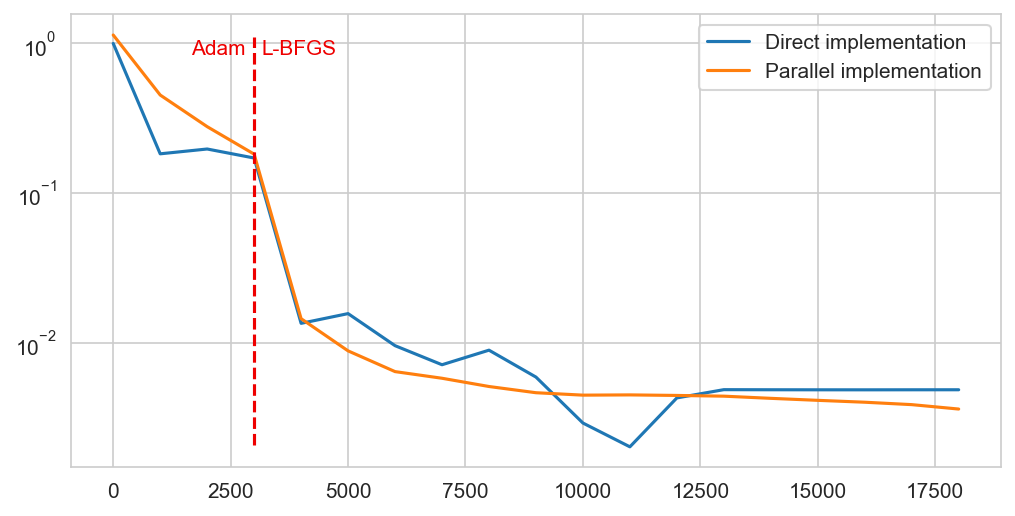

In [14]:
# first run to check the implementation before doing hyperparameter optimization
config["optimizers"] = ["adam","L-BFGS"] #3000 iterations with Adam, then L-BFGS
config['learning_rates'] = [1e-3,None] #no learning rate for L-BFGS
config["iterations"] = [3000,None] #no iterations for L-BFGS

config['net_type'] = 'Unet'
model_direct = model_setup(geom,config)
loss_hist_direct, train_state_direct = train_model(model_direct,config)

config['net_type'] = 'USnet'
model_parallel = model_setup(geom,config)
loss_hist_parallel, train_state_parallel = train_model(model_parallel,config)

#plotting the loss history
steps = np.array(loss_hist_direct.steps).squeeze()
metrics_direct = np.array(loss_hist_direct.metrics_test).squeeze()
metrics_parallel = np.array(loss_hist_parallel.metrics_test).squeeze()

accuracy_plot, ax = plt.subplots(1,1,figsize = (8,4),dpi = 150)
ax.plot(steps,metrics_direct,steps,metrics_parallel)
plt.yscale('log')
ax.legend(["Direct implementation","Parallel implementation"])
ax.axvline(x=3000, ymin=0.05, ymax=0.95, color='#EE0000',ls='--')
ax.text(1650, 0.85, 'Adam',color="#EE0000")
ax.text(3150, 0.85, 'L-BFGS',color="#EE0000")

#save run
fname = r"results/mixed_BVP/first_run" #folder to save results (should exist)
save_run = True
if save_run:
    #saving trained models 
    model_direct.compile("adam", lr=0.1, metrics=["l2 relative error"])
    model_direct.train(iterations=0,model_save_path=os.path.join(fname, "model_direct"))
    model_parallel.compile("adam", lr=0.1, metrics=["l2 relative error"])
    model_parallel.train(iterations=0,model_save_path=os.path.join(fname, "model_parallel"))
    
    #saving loss history
    dde.utils.external.save_loss_history(loss_hist_direct, os.path.join(fname,'loss_history_direct.dat'))
    dde.utils.external.save_loss_history(loss_hist_parallel, os.path.join(fname,'loss_history_parallel.dat'))
    accuracy_plot.savefig( os.path.join(fname,"accuracy_history_plot.png"), dpi=150)

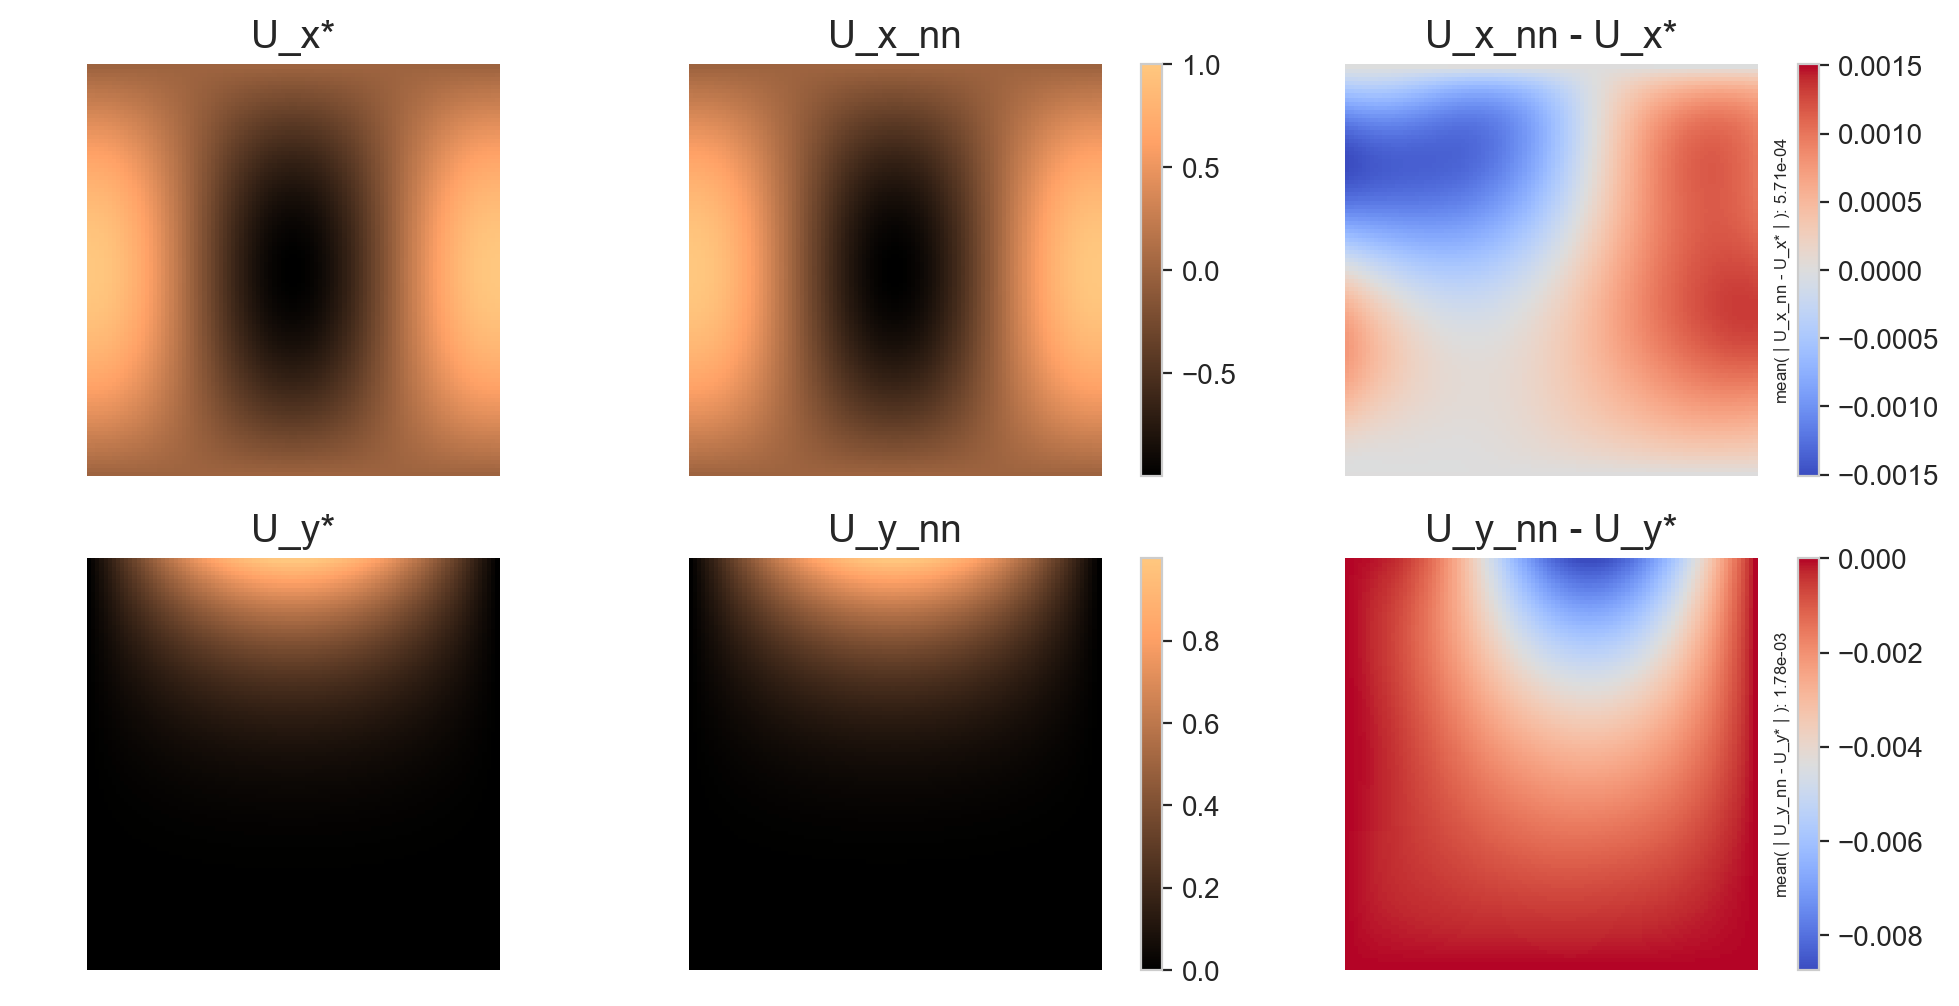

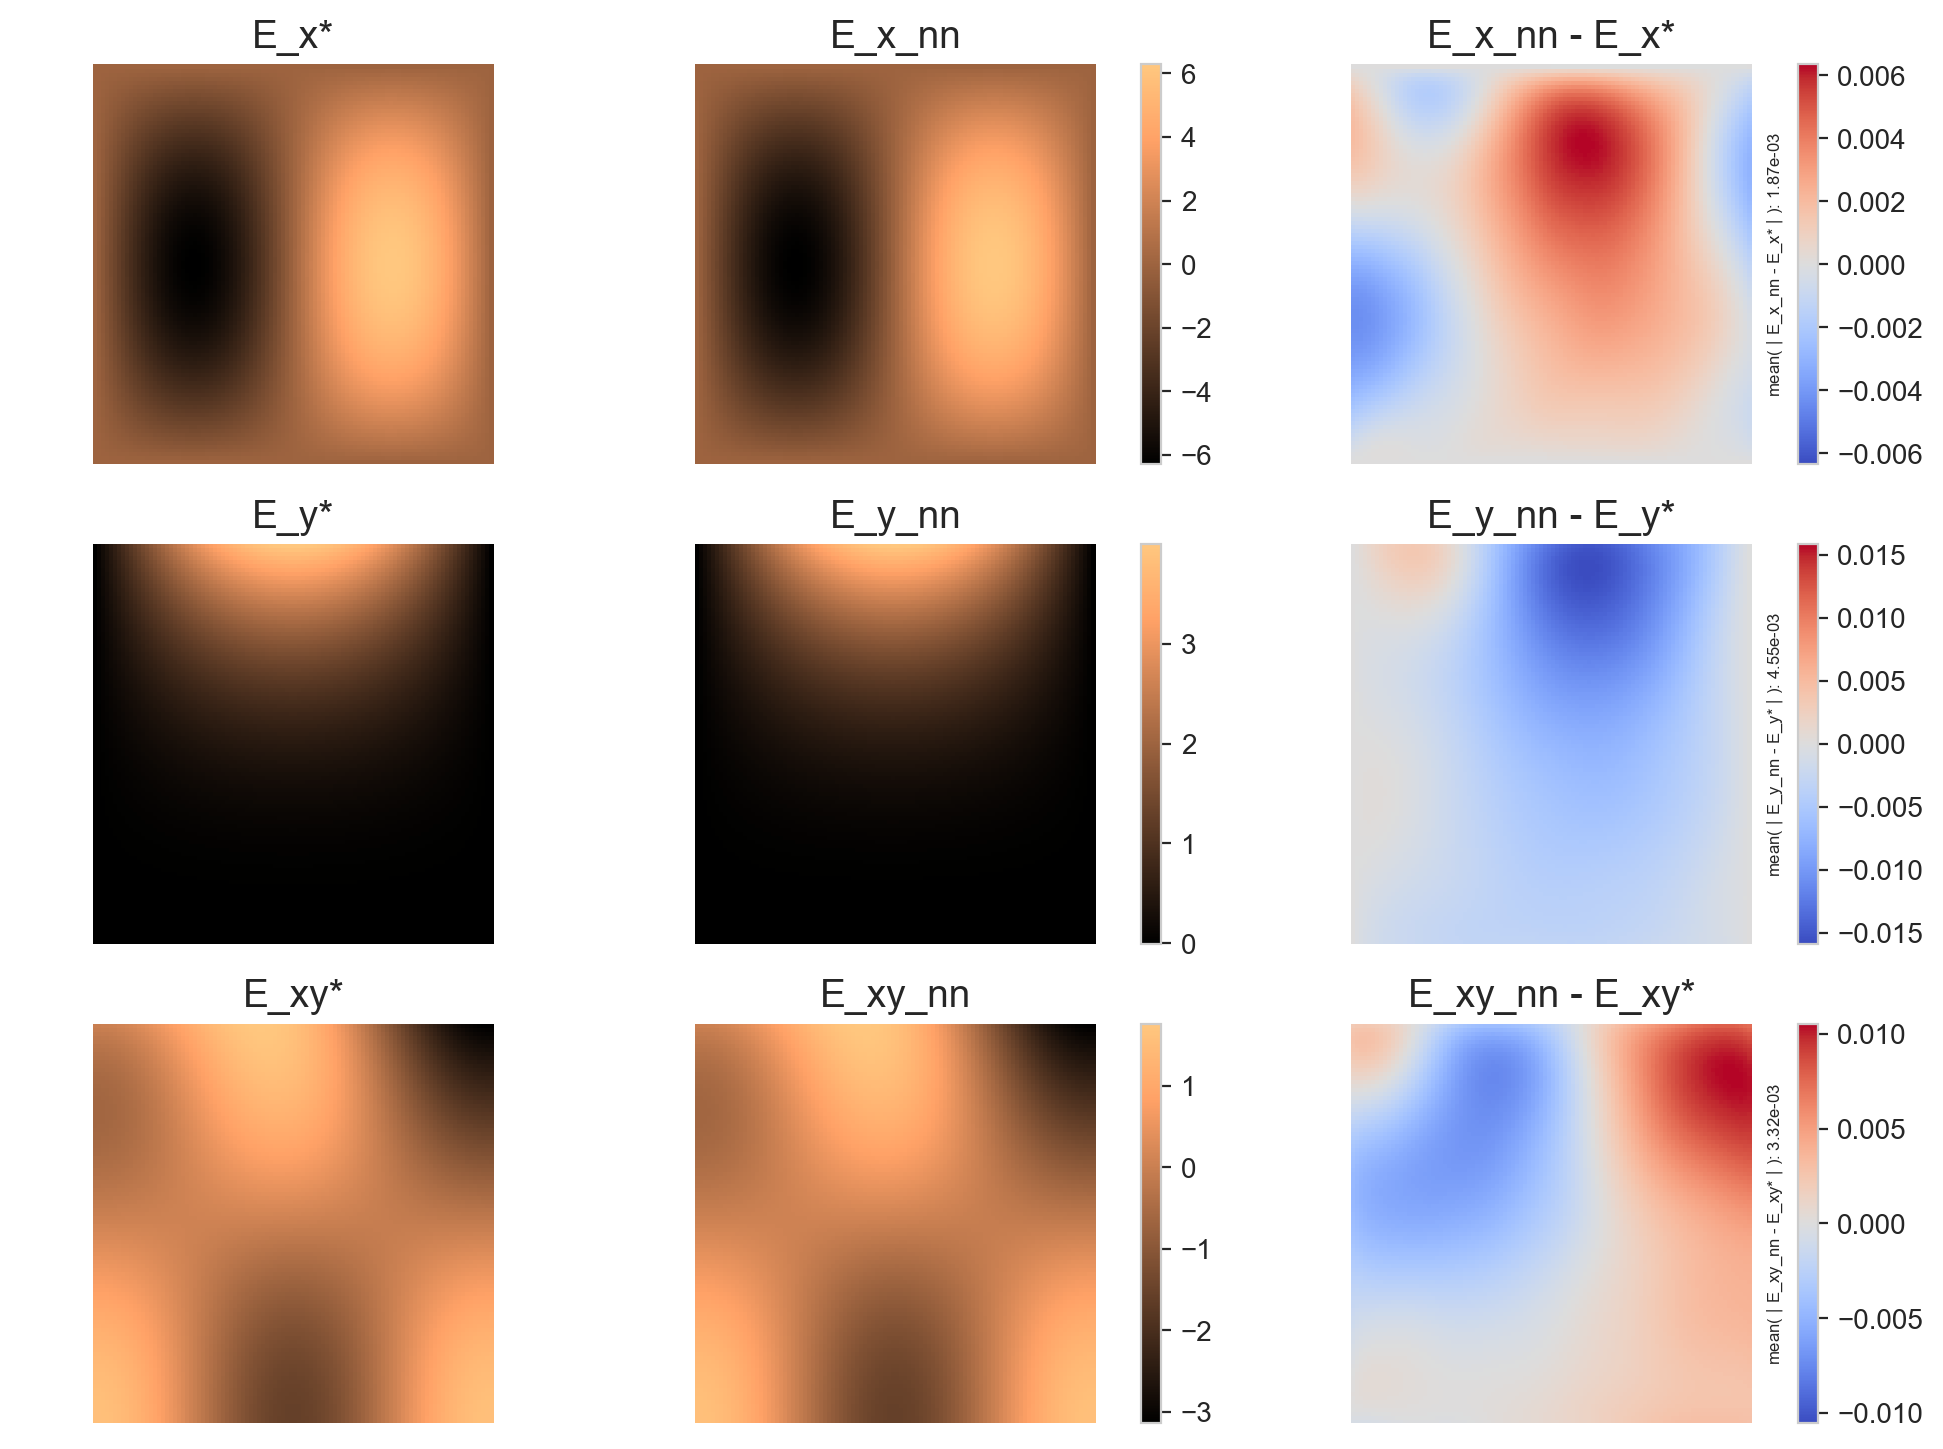

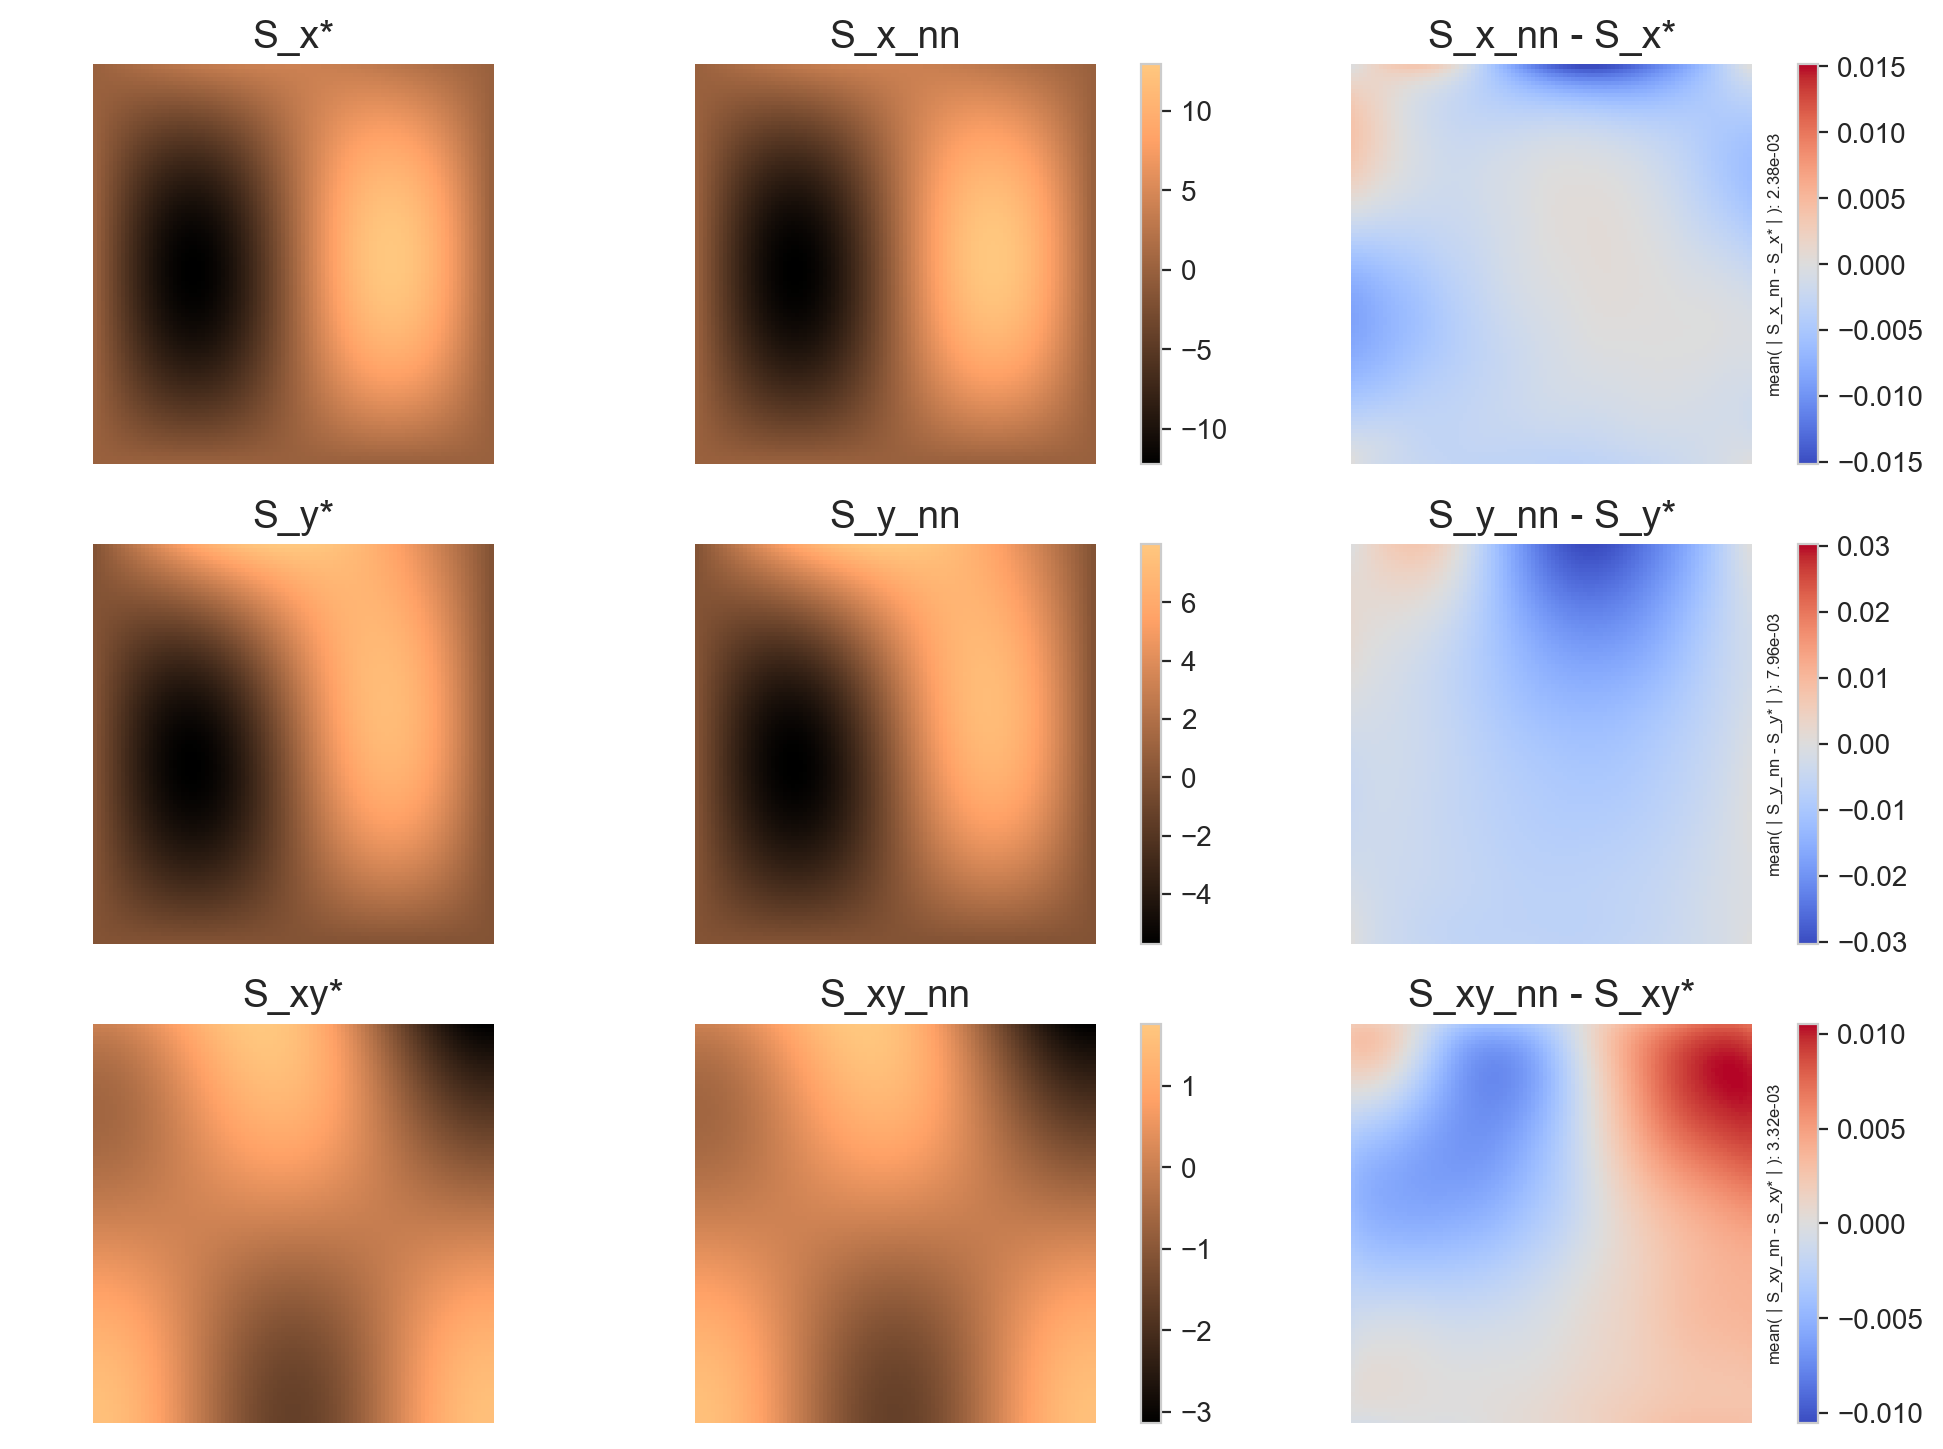

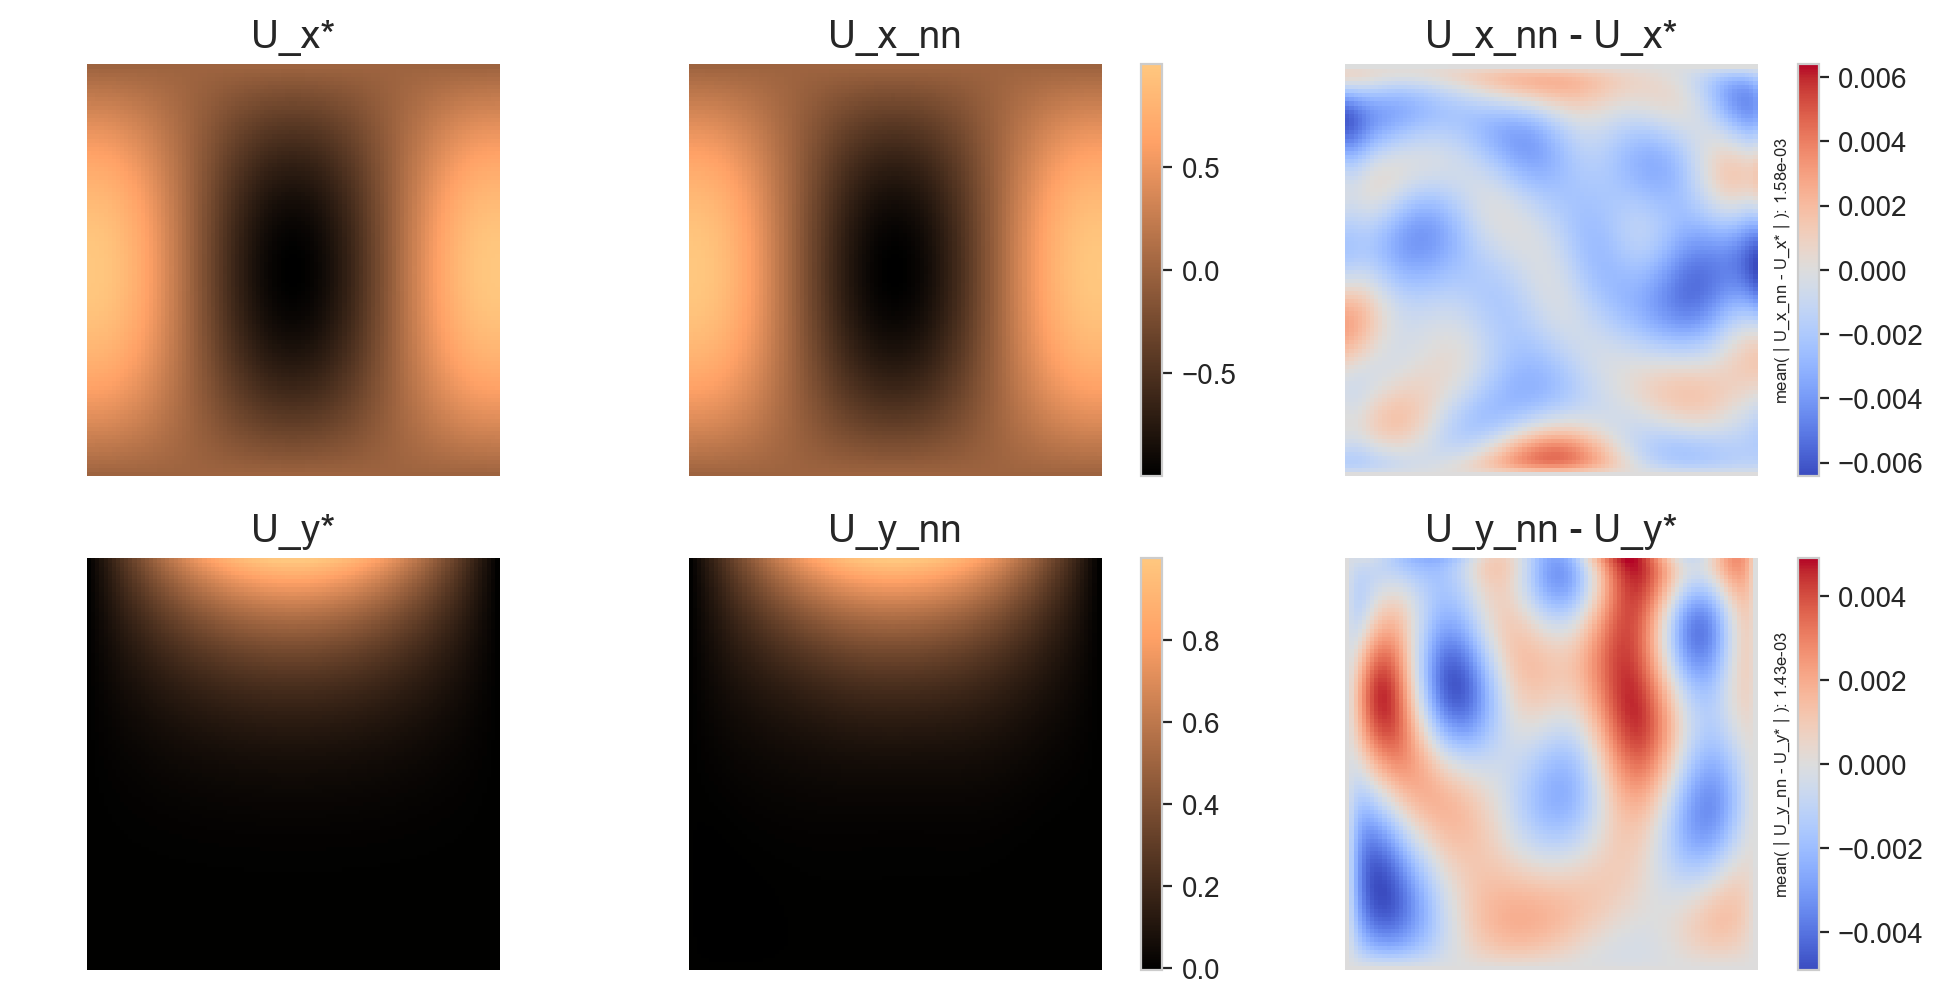

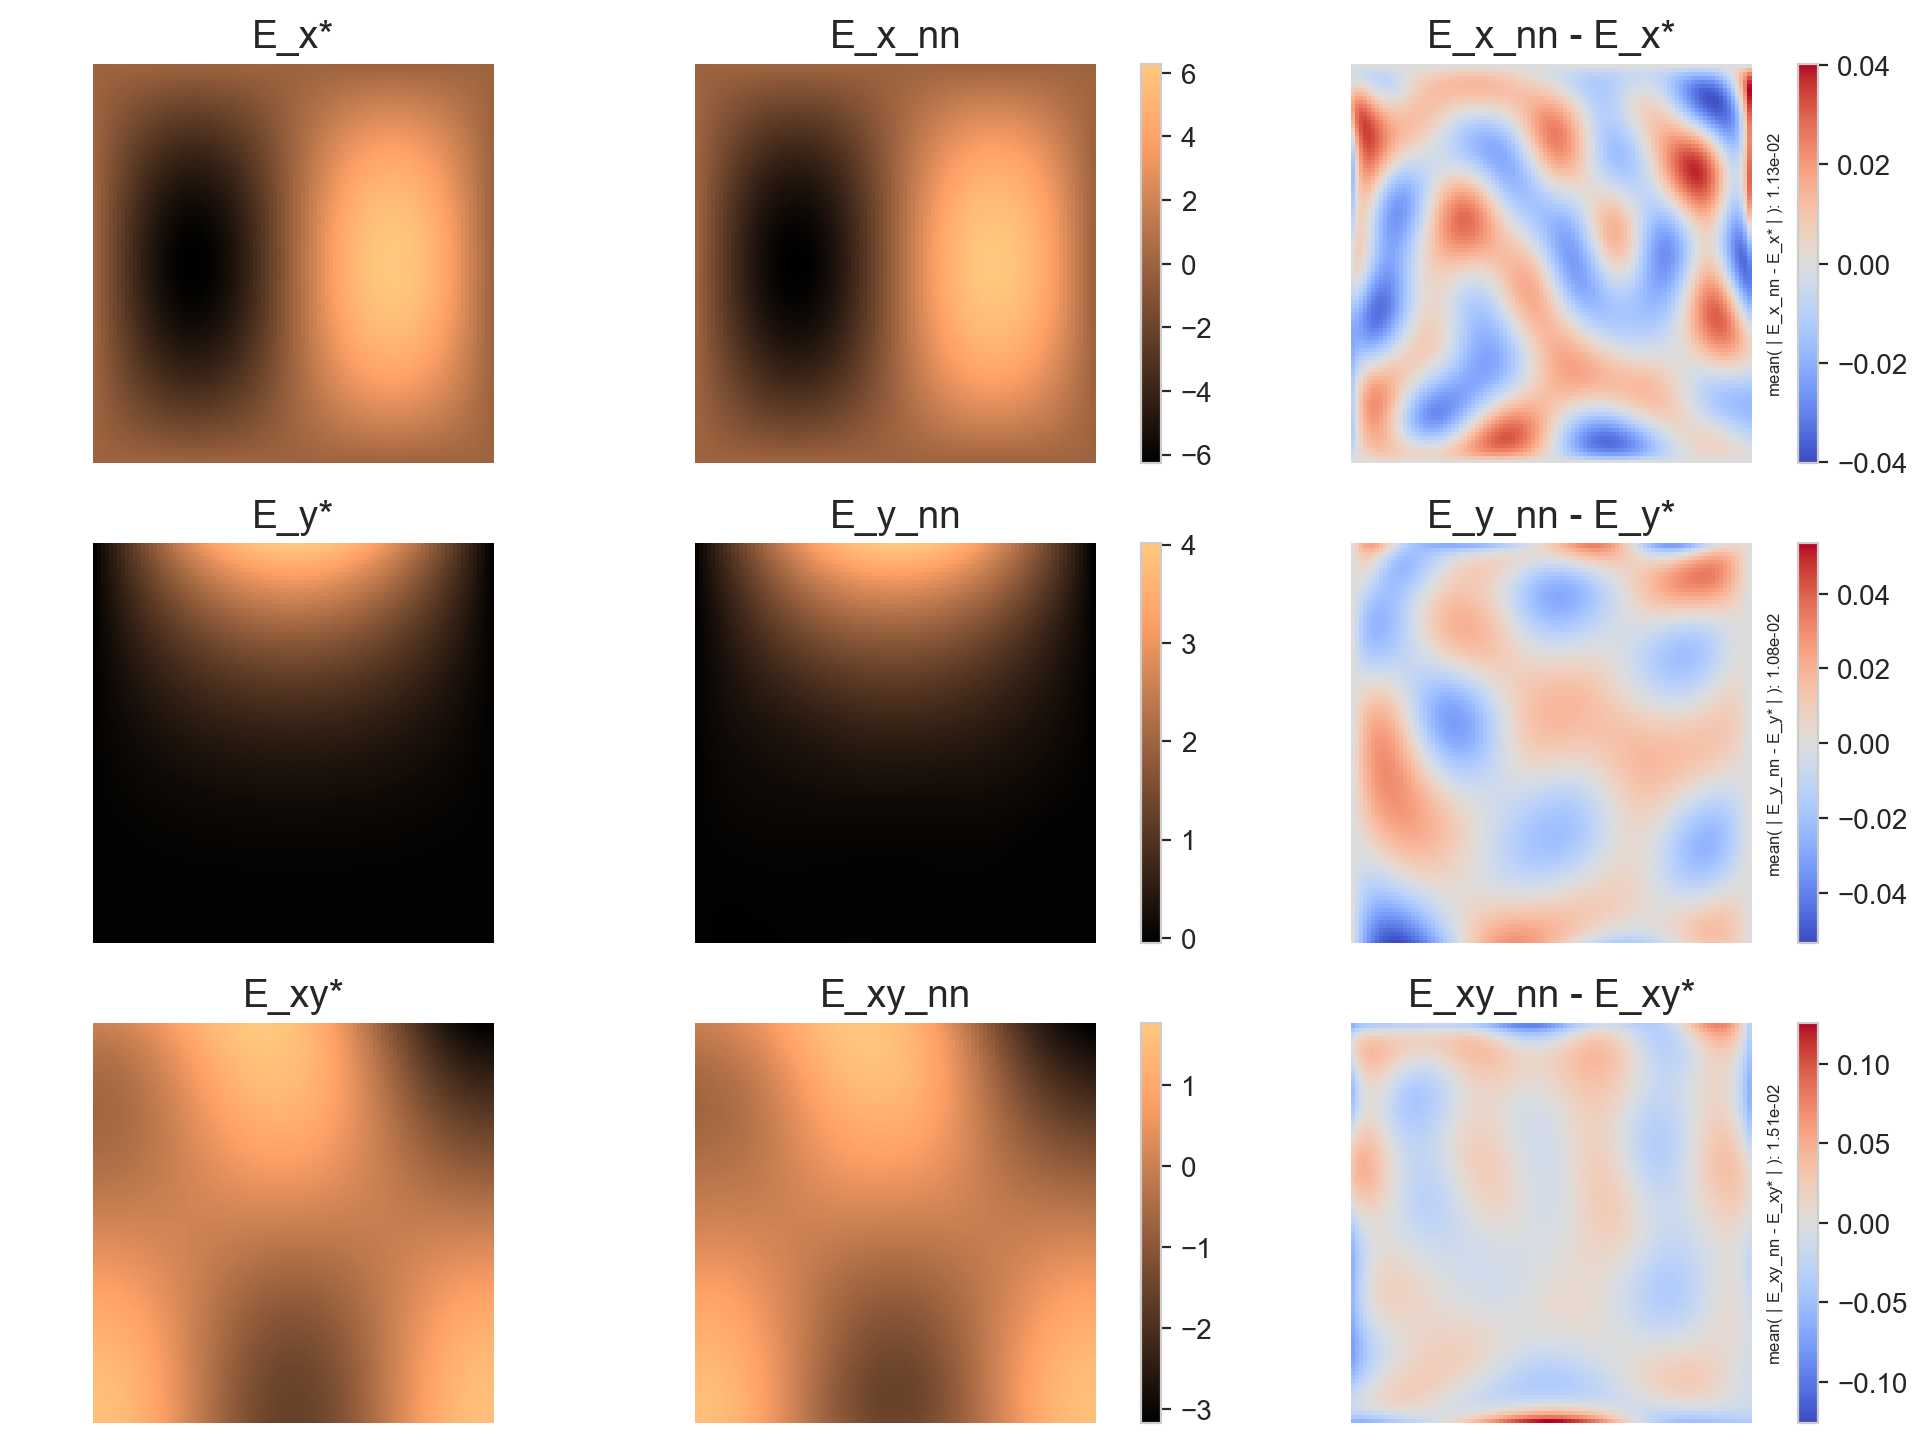

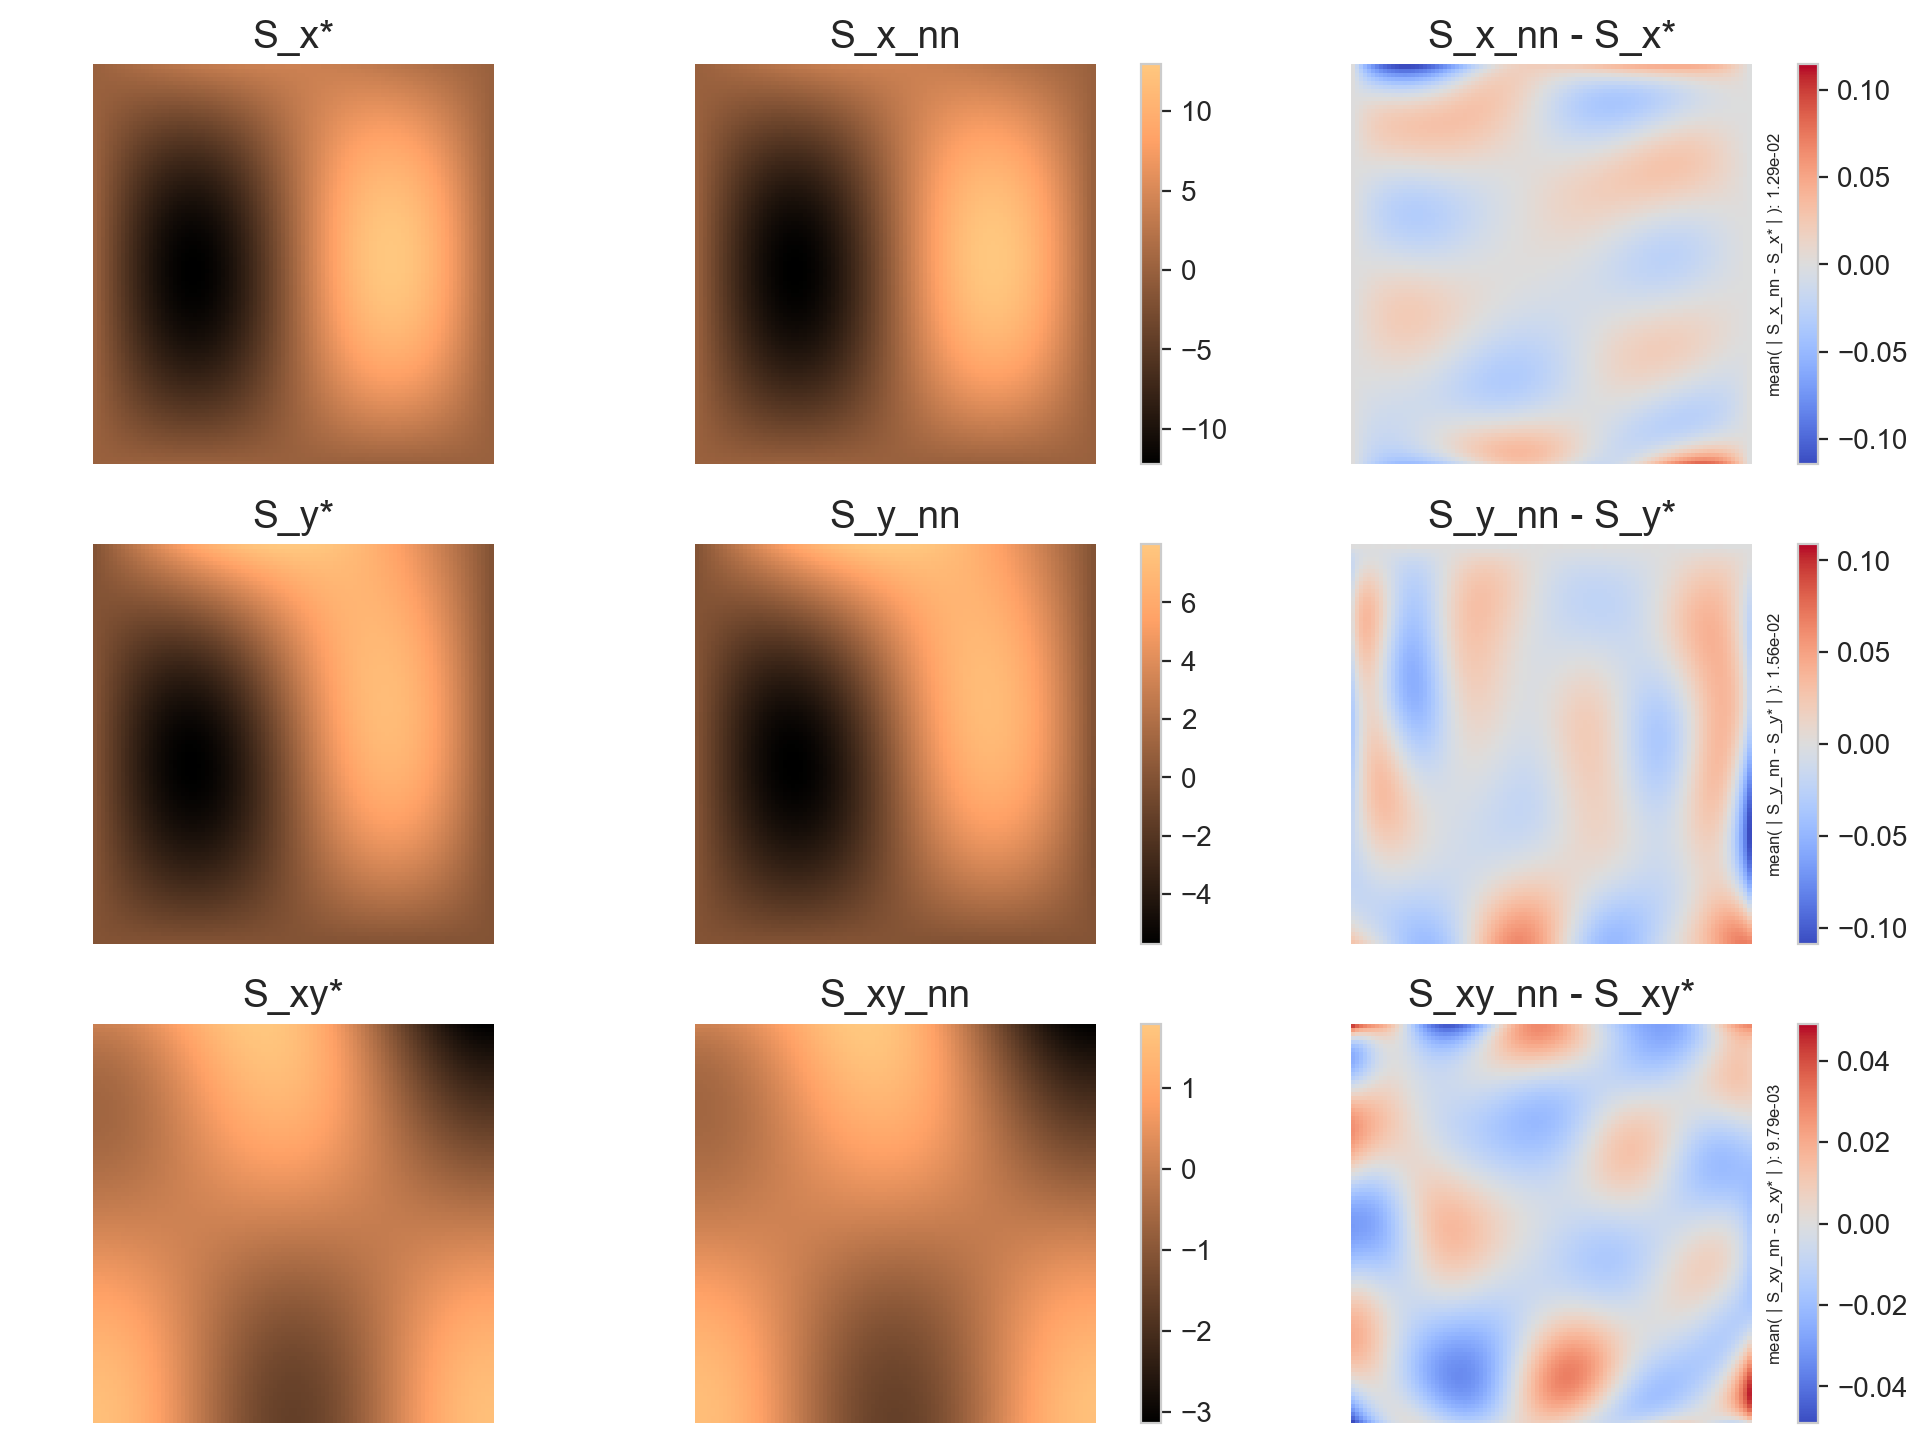

In [18]:
# plot solutions after training
U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: S_nn(E_nn(x,ouput)) 

direct_U = plot_field(domain,model_direct,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
direct_E = plot_field(domain,model_direct,output_func=E_nn,V_exact=E_exact,plot_diff=True)
direct_S = plot_field(domain,model_direct,output_func=S_output,V_exact=S_exact,plot_diff=True)

S_output = lambda x, ouput: (ouput[:,2], ouput[:,3], ouput[:,4]) 

parallel_U = plot_field(domain,model_parallel,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
parallel_E = plot_field(domain,model_parallel,output_func=E_nn,V_exact=E_exact,plot_diff=True)
parallel_S = plot_field(domain,model_parallel,output_func=S_output,V_exact=S_exact,plot_diff=True)

save_plot = True
if save_plot:
    direct_U.savefig(os.path.join(fname,"U_direct.png"), dpi=150)
    direct_E.savefig(os.path.join(fname,"E_direct.png"), dpi=150)
    direct_S.savefig(os.path.join(fname,"S_direct.png"), dpi=150)

    parallel_U.savefig(os.path.join(fname,"U_parallel.png"), dpi=150)
    parallel_E.savefig(os.path.join(fname,"E_parallel.png"), dpi=150)
    parallel_S.savefig(os.path.join(fname,"S_parallel.png"), dpi=150)

## Hyperparameter optimization
The HPO can also be runned in the "HPO/HPO.ipynb" notebook that imports all the functions from this notebook (duplicate in mixed_BVP.py), thus avoiding the need to run the whole notebook.

In [ ]:
# hyperparameter optimization with Weights and Biases
def log_run(config,losshistory):
    """Log the run to wandb"""
    steps = np.array(losshistory.steps).squeeze() 
    losses_train = np.array(losshistory.loss_train).squeeze().sum(axis=1)
    losses_test = np.array(losshistory.loss_test).squeeze().sum(axis=1)
    metrics = np.array(losshistory.metrics_test).squeeze()

    for i in range(len(steps)):
        wandb.log({"steps": steps[i], "loss_train": losses_train[i], "loss_test": losses_test[i], "accuracy_metric": metrics[i]})

def wandb_train(config=None):
    dde.optimizers.config.set_LBFGS_options(maxiter=10000)
    save_model = True
    with wandb.init(project="HPO-PINN-CM", config=config):
        config = wandb.config
        config["num_domain"] = config["num_samples"]**2
        config["num_boundary"] = config["num_samples"]
        model = model_setup(geom,config)
        model_save_path = os.path.join(wandb.run.dir, "model") if save_model else None
        losshistory, train_state = train_model(model,config,model_save_path=model_save_path)
        log_run(config,losshistory)

In [ ]:
# Initialize the wandb sweep with the possible values for the hyperparameters
sweep_dict = {
    'net_type': {'values': ['Unet','USnet']},
    'n_layers': { 'max': 10,'min': 2},
    'size_layers': {'values': [50,75,100]},
    'activation': {'values': ['tanh','sigmoid']},
    'loss_type': {'values':  ['pde']},
    'num_samples': {'values': [25,50,75,100]},
    'bc_type': {'value': 'hard'},
    'train_distribution': {'value': 'Hammersley'},
    'optimizers': {'value': ["adam","L-BFGS"]},
    'learning_rates': {'value': [1e-3,None]},
    'iterations': {'value': [3000,None]}
}

#Bayesian updating hyper-optimization to minimize accuracy metric
sweep_config = {
    'method': 'bayes',
    'parameters': sweep_dict,
    'metric': {
        'name': 'accuracy_metric',
        'goal': 'minimize'   
    },
    'name': 'sweep-1',
    'program': 'mixed_BVP.py'
}

project_name = 'HPO-PINN-CM'
sweep_id = wandb.sweep(sweep_config, project=project_name)

In [ ]:
# Launch the sweep agent
sweep_id = "hsnp1x74"
count = 10

wandb.agent(sweep_id, wandb_train, count=count)